
# Climate Change in Bozeman, Montana

This notebook will analyze temperature data in Bozeman, MT to investigate for a warming trend due to climate change. I am using data from the NCEI - Station (PUT_STATION_HERE). I'll be using a simple linear regression to do this analysis, which is certainly a limited tool, but is a good place to start.

DISCUSSION OF LR ASSUMPTIONS HERE

If time allows, I'd also like to investigate snowfall amounts for a climate change signal. However, that will be a little bit harder, as precipitation data on a daily scale is a non-Gaussian data product.

## To-Do

- [ ] Finish documentation of Bozeman weather station once link works again
- [ ] Add discussion of LR Assumptions
- [ ] Complete Bozeman Tobs analysis
- [ ] Tackle Bozeman snowfall analysis?


In [1]:
# Import libraries (all that will be needed for this project)

import earthpy # local data management
import pandas as pd
import numpy as np
import hvplot.pandas # For making an interactive plot
import holoviews as hv
import matplotlib.pyplot as plt # advanced plotting options
import seaborn as sns # statistical plots for tabular data
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression

print('Done!')

c:\Users\raini\miniconda3\envs\earth-analytics-python\Lib\site-packages\earthpy\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


Done!


## Import the Data and Organize into a DataFrame

Add some descriptive text here
- Where from
- Station info
- etc


In [2]:
# Access Observed Temperature data from the Bozeman Weather station

bzn_tobs_url = ('https://www.ncei.noaa.gov/access/services/da'
'ta/v1?dataset=daily-summaries&dataTypes=TOBS&stations=USC00241044&'
'startDate=1892-04-08&endDate=2025-09-25&units=standard')


bzn_tobs_url

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TOBS&stations=USC00241044&startDate=1892-04-08&endDate=2025-09-25&units=standard'

In [3]:
# Download the climate data
# I'm storing the Tobs data in bzn_t_df_raw
bzn_t_raw_df = pd.read_csv(
    bzn_tobs_url,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check that the download worked
bzn_t_raw_df.tail()

,STATION,TOBS
DATE,,
2025-09-21,USC00241044,69.0
2025-09-22,USC00241044,60.0
2025-09-23,USC00241044,67.0
2025-09-24,USC00241044,79.0
2025-09-25,USC00241044,80.0


In [4]:
# Save the climate data for later use

bzn_t_raw_df.to_csv('bozeman_tobs_1892-2025')


## Plot the data to start looking at them


In [5]:
# Check that the data were imported to a DataFrame

type(bzn_t_raw_df)

pandas.core.frame.DataFrame

<Axes: ylabel='Frequency'>

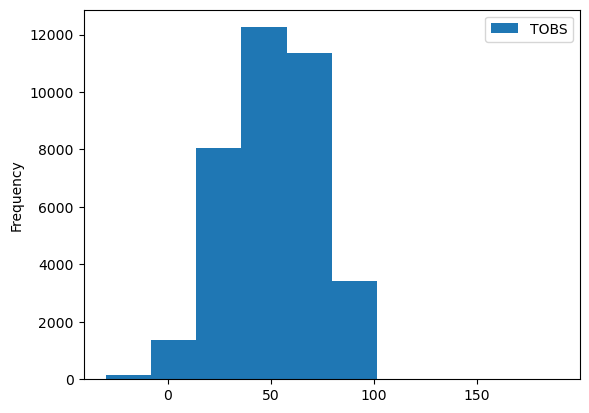

In [6]:
# Plot the data as a histogram to check that NaNs were imported correctly

bzn_t_raw_df.plot.hist()

<Axes: title={'center': 'Daily Temperature in Bozeman, MT'}, xlabel='Year', ylabel='Temperature ($^\\circ$F)'>

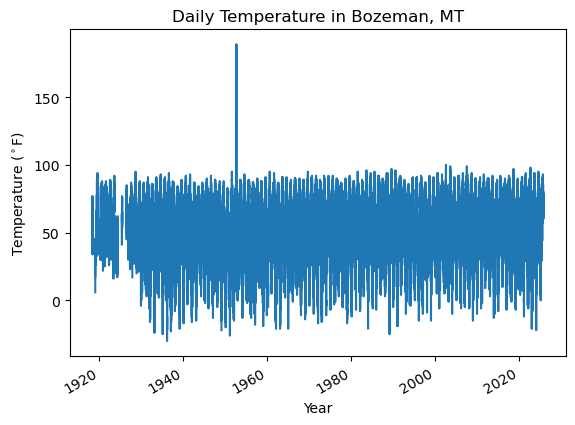

In [7]:
# Plot data as a line plot

bzn_t_raw_df.plot(
    y= 'TOBS',
    title='Daily Temperature in Bozeman, MT',
    xlabel='Year',
    ylabel='Temperature ($^\circ$F)',
    legend=False
    )

### Interpretation

There are two interesting things in this dataset. 

First, there is what must be a wildly erroneous value of nearly 200&deg;F between 1940 and 1950. This error should be minimized by working with the annual mean.

Second, from the beginning of the timeseries to roughly 1950 there are almost no temperatures close to 0 &deg;F, which, I doubt is accurate. This will require some digging into to figure out what's going on and how to address this.

## Data Cleaning

I'll need to clean the dataset up a little bit to make it easier to work with. I need to:
- Remove the station ID
- Remove NaNs
- Adds a column converted to Celcius
- Remove years with large amounts of missing data

Removing the years with missing data is the most concerning and challenging step. Here's why I'm doing this:

The first line plot shows that there is something weird going on in the first part of the 1900s in the dataset. Using an extension (DataWrangler, from Microsoft), I've taken a look at the beginning of the dataset, and each year until 1933 is missing at least a month of data - often multiple months at a time. So, it seems fairly reasonable to exlude any data from before 1933, as the data aren't reliable enough to make an sort of statistical analysis. In addition, I've got information from most of 2025, but not all, so we'll want to exclude that.


In [8]:
# Clean up the DataFrame items and labels

# This step removes Station ID name as we don't need it in the DF,
# removes years with many NaNs, it renames 'TOBS' to temp_f, 
# and adds a column converted to Celsius.

bzn_t_int_df = bzn_t_raw_df[['TOBS']]
bzn_t_df = bzn_t_int_df[(
    pd.to_datetime(bzn_t_raw_df.index).year >= 1933) 
    & 
    (pd.to_datetime(bzn_t_raw_df.index).year <= 2024)]
bzn_t_df = bzn_t_df.dropna()
bzn_t_df = bzn_t_df.rename(columns={'TOBS':'temp_f'})
bzn_t_df['temp_c'] = (bzn_t_df['temp_f'] - 32) * (5 / 9)
bzn_t_df

,temp_f,temp_c
DATE,,
1933-01-01,25.0,-3.888889
1933-01-02,37.0,2.777778
1933-01-03,15.0,-9.444444
1933-01-04,35.0,1.666667
1933-01-05,40.0,4.444444
...,...,...
2024-12-27,35.0,1.666667
2024-12-28,38.0,3.333333
2024-12-29,34.0,1.111111


# Looking into the data a bit more here
# As it turns out, this way could have worked, but I feel pretty good 
# about just looking through the dataframe. I'm going to save this for now though.

s = bzn_t_raw_df[pd.to_datetime(bzn_t_raw_df.index).year == 1925]
# Awesome! So I can use this formula to pull out years:
# df[pd.to_datetime(df.index).year == YYYY]
# Presumably I could use more conditionals to pull out a length of years

s.isna().sum()
# This tells me how many entries in the given year are NaNs
# I think I can write a for loop to check every year.

# For loop to check how many NaNs are in each year

# Make an index for the for loop
ind = pd.date_range("1892", "2024", freq="A").year
ind


# This variable will store the number of NaNs in each year
check_nan = []

for item in ind:
    s = bzn_t_raw_df[pd.to_datetime(bzn_t_raw_df.index).year == item]
    check_nan[item] = s['TOBS'].isna().sum()



## Plotting the Data

<Axes: title={'center': 'Daily Temperature in Bozeman, MT'}, xlabel='Year', ylabel='Temperature ($^\\circ$F)'>

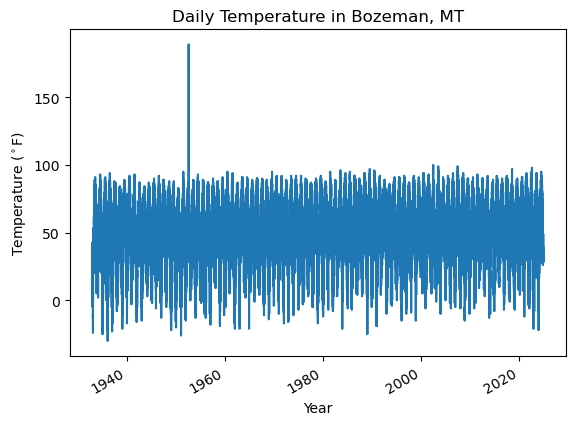

In [9]:
# Plot data as a line plot

bzn_t_df.plot(
    y= 'temp_f',
    title='Daily Temperature in Bozeman, MT',
    xlabel='Year',
    ylabel='Temperature ($^\circ$F)',
    legend=False
    )

This plot looks much more like what I'd expect to see.


## Resample the data to an annual mean and plot interactively


In [10]:
# Resample the data

bzn_t_ann_df = bzn_t_df.resample('YE').mean()
bzn_t_ann_df

,temp_f,temp_c
DATE,,
1933-12-31,48.652055,9.251142
1934-12-31,52.613699,11.452055
1935-12-31,47.432877,8.573820
1936-12-31,48.010929,8.894961
1937-12-31,46.830137,8.238965
...,...,...
2020-12-31,52.147945,11.193303
2021-12-31,53.468493,11.926941
2022-12-31,51.052055,10.584475


<Axes: title={'center': 'Daily Temperature in Bozeman, MT'}, xlabel='Year', ylabel='Temperature ($^\\circ$ F)'>

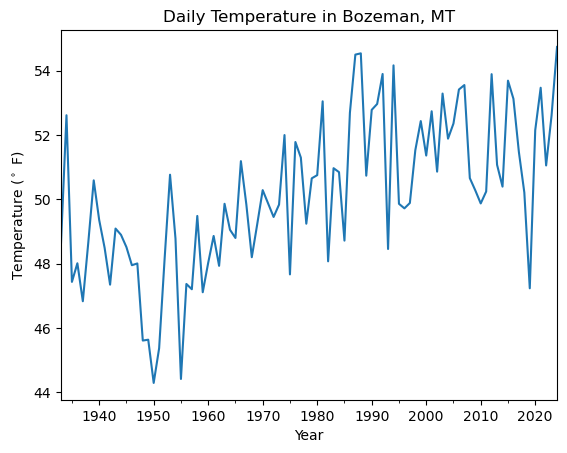

In [11]:
# Plot the data to make sure this looks better

bzn_t_ann_plot = bzn_t_ann_df.plot(
    y= 'temp_f',
    title='Daily Temperature in Bozeman, MT',
    xlabel='Year',
    ylabel='Temperature ($^\circ$ F)',
    legend=False
)

bzn_t_ann_plot

### Interpretation

The erroneous high value has been smoothed out, as I suspected. In addition, it looks like there's a pretty clear warming trend going on in the data.

In [12]:
# Make an interactive plot

bzn_t_ann_plot_int = bzn_t_ann_df.hvplot(
    y= 'temp_f',
    title='Daily Temperature in Bozeman, MT',
    xlabel='Year',
    ylabel='Temperature ($^\circ$ F)',
    legend=False   
)

bzn_t_ann_plot_int

# Save plot

hv.save(bzn_t_ann_plot_int, 'bzn_t_ann_plot_int.html')


## Fit a linear regression to the data


In [13]:
# Fit an OLS Linear Regression to the data (ChatGPT query)
# I have marked ChatGPT comments with double hashtags (##)

from sklearn.linear_model import LinearRegression
import numpy as np

# Reset the DataFrame index to a column within the DataFrame. I have abbreviated the 
# variable name to bzn_t_reind_df so it doesn't get unwieldy.
## Assuming df is your DataFrame with 'Year' as the index and 'Temperature' as the column
bzn_t_reind_df = bzn_t_ann_df.reset_index()

# Further clean the DataFrame to work with Seaborn and scikit.
# The way 'DATE' is formatted causes errors with regplot(), so I need to just select the 
# year out of 'DATE'.
# Clean the data of NaNs before calculating the fit (Google Gemini)

bzn_t_reind_df['DATE'] = pd.to_datetime(bzn_t_reind_df['DATE'])
bzn_t_reind_df['year'] = bzn_t_reind_df['DATE'].dt.year
bzn_t_lin_reg_df = bzn_t_reind_df.dropna()

## Reshape 'Year' column to be a 2D array for scikit-learn
x = bzn_t_lin_reg_df[['year']].values
y_f = bzn_t_lin_reg_df['temp_f'].values

## Create and fit the linear regression model
model = LinearRegression()
model.fit(x, y_f)

## Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

## Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

Slope: 0.05656073398035132
Intercept: -61.755624609733154



## Plot the linear regression


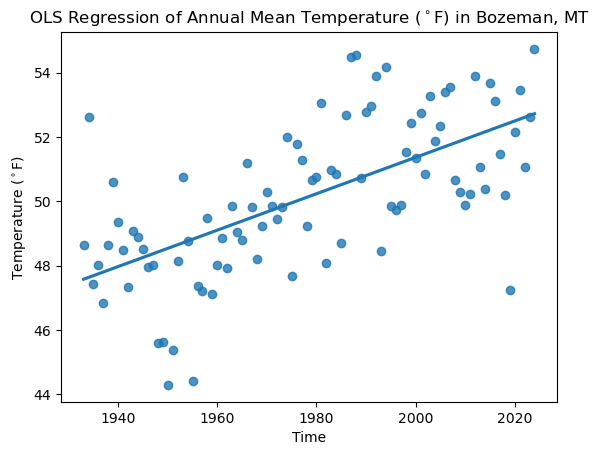

In [14]:
# Plot annual average temperature with a trend line
bzn_plot_linreg = sns.regplot(
    x= bzn_t_lin_reg_df[['year']], 
    y= bzn_t_lin_reg_df[['temp_f']],
    data= bzn_t_lin_reg_df,
    # type = 'line'
    ci= None
)
# Set plot labels
bzn_plot_linreg.set(
    title='OLS Regression of Annual Mean Temperature ($^\circ$F) in Bozeman, MT',
    xlabel='Time',
    ylabel='Temperature ($^\circ$F)'
)
# Save figure andDisplay the plot without extra text
plt.savefig('bzn_plot_linreg.png')
plt.show()


## Wrap up the notebook and get ready to make a portfolio post
